In [1]:
## data
import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta
from unicodedata import normalize

## vis
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
# contagem de aging
from collections import Counter

from IPython.display import display, HTML

## modelo
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.metrics import average_precision_score, mean_absolute_error, roc_curve, auc, roc_auc_score
from scikitplot.metrics import plot_roc
from sklearn.model_selection import cross_val_score

# check xgboost version
from xgboost import XGBClassifier, XGBRegressor

import dill as pickle

## alertas
import warnings
warnings.filterwarnings("ignore")

c:\Users\drodriguesr\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


***
### Funções

In [2]:
def aucur(y_test, preds):
    # calculate AUC
    aucur = roc_auc_score(y_test, preds)
    print('AUC: %.3f' % aucur)

    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y_test, preds)

    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    # show the plot
    plt.show()

In [3]:
def just_check_nan(df):
    # Check NaN Pandas and Numpy
    missing_val_count_by_column = (df.isna().sum())

    columns_with_nan = missing_val_count_by_column[missing_val_count_by_column > 0]
    print('Dados com NaN:')
    print(columns_with_nan)
    print('')
    print('columns_with_nan.shape', columns_with_nan.shape)
    print('')

In [4]:
def plot_feature_freq(df, feature):
    labels, counts = np.unique(df[feature].dropna(), return_counts=True)
    total = counts[0] + counts[1]
    plt.figure(figsize=(10, 7))
    ax = sns.barplot(x=labels, y=(counts/total)*100, data = df)
    ax2 = sns.barplot(x=labels, y=counts, data = df)

    for p in ax.patches:
        ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x() + 0.3, p.get_height()+0.6), rotation = 0)

#     ax.set(xlabel='Trocou', ylabel='Porcentagem')
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    plt.show()

In [6]:
def plot_feature_freq_mes(df, feature):
    labels, counts = np.unique(df[feature].dropna(), return_counts=True)
    total = counts[0] + counts[1] + counts[2] + counts[3] + counts[4] + counts[5] + counts[6]
    plt.figure(figsize=(10, 7))
    ax = sns.barplot(x=labels, y=(counts/total)*100, data = df)
    ax2 = sns.barplot(x=labels, y=counts, data = df)

    for p in ax.patches:
        ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x() + 0.3, p.get_height()+0.6), rotation = 0)

#     ax.set(xlabel='Trocou', ylabel='Porcentagem')
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    plt.show()

***
## Coleta de dados

In [7]:
FILE = "../datasets/pca_tem_clientes_devicemanger_bat2_prod.csv"

In [8]:
client_chunks = []
dados_teste = pd.read_csv(FILE, sep = ";", 
                          header = 0, 
                          index_col = False, 
                          names = None, 
                          low_memory = False, 
                          chunksize = 10**5) 

In [9]:
for chunk in dados_teste:

    new_clients = pd.DataFrame(chunk)

    # filter data chunk with frac percentage
#     new_clients = new_clients.sample(frac = 0.5)
    new_clients = new_clients.drop_duplicates()

    # saves to list
    client_chunks.append(new_clients)

dados = pd.concat(client_chunks).reset_index(drop = True)

In [11]:
# FILE = "/kaggle/input/datasetsnew/batdtfim500kage.csv"
# dados = pd.read_csv(FILE, sep = ';', encoding = 'ISO-8859-1', engine ='python')

dados = dados.rename(columns={' a.msisdn': 'msisdn'})\
             .rename(columns={'a.imsi': 'imsi'})\
             .rename(columns={'a.tac': 'tac'})\
             .rename(columns={'a.dt_inicio': 'dt_inicio'})\
             .rename(columns={'a.dt_fim': 'dt_fim'})\
             .rename(columns={'a.aging_aparelho': 'aging_aparelho'})\
             .rename(columns={'a.aging_year': 'cat_aparelho'})\
             .rename(columns={'a.trocou_aparelho': 'trocou_aparelho'})\
             .rename(columns={'a.fabricante': 'fabricante'})\
             .rename(columns={'a.modelo': 'modelo'})\
             .rename(columns={'a.imei': 'imei'})\
             .rename(columns={'a.ranking': 'ranking'})\
             .rename(columns={'a.cpfidentifier': 'cpfidentifier'})\
             .rename(columns={'a.subscriberkey': 'subscriberkey'})\
             .rename(columns={'a.customerkey': 'customerkey'})\
             .rename(columns={'a.customersubtypedesc': 'customersubtypedesc'})\
             .rename(columns={'a.subscriberstatuskey': 'subscriberstatuskey'})\
             .rename(columns={'a.offertechnology': 'offertechnology'})\
             .rename(columns={'a.citydesc': 'citydesc'})\
             .rename(columns={'a.statedesc': 'statedesc'})\
             .rename(columns={'a.subscribermainofferdesc': 'subscribermainofferdesc'})\
             .rename(columns={'a.assignedchargeamount': 'assignedchargeamount'})\
             .rename(columns={'a.fl_3g': 'fl_3g'})\
             .rename(columns={'a.fl_4g': 'fl_4g'})\
             .rename(columns={'a.fl_5g': 'fl_5g'})\
             .rename(columns={'a.dt_ano_stts': 'dt_ano_stts'})\
             .rename(columns={'a.age': 'idade'})\
             .rename(columns={'a.avg_msisdn': 'avg_msisdn'})\
             .rename(columns={'a.avg_cpf': 'avg_cpf'})\

dados

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,trocou_aparelho,fabricante,modelo,...,citydesc,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,dt_ano_stts,idade,avg_msisdn,avg_cpf
0,5537998231861,724233765873941,35421469,2021-08-09,NaN,17,1,0,"Motorola Mobility LLC, a Lenovo Company",MOTO E(6)S,...,ARCOS,MINAS GERAIS,VIVO CONTROLE 4GB,41.93,0.0,1.0,2021.0,68.0,0.0,0.0
1,5551997225363,724065191492347,35223467,2021-10-24,NaN,14,1,0,"Motorola Mobility LLC, a Lenovo Company",MOTO G(9) PLAY,...,NOSSA SENHORA DO SOCORRO,SERGIPE,VIVO CTRL DIGITAL-9GB_,62.40,0.0,1.0,2021.0,39.0,0.0,0.0
2,5531996330364,724233406091372,35450612,2021-10-01,NaN,15,1,0,APPLE,IPHONE 12 PRO MAX (A2342),...,BELO HORIZONTE,MINAS GERAIS,CONTROLE MÚSICA 10GB,69.99,0.0,0.0,2021.0,48.0,0.0,0.0
3,5554996866600,724065010907570,35456077,2021-12-08,NaN,13,1,0,"Motorola Mobility LLC, a Lenovo Company",MOTO E(6)I,...,BENTO GONCALVES,RIO GRANDE DO SUL,VIVO CONTROLE 9GB I,56.49,0.0,1.0,2021.0,39.0,0.0,0.0
4,5596991621965,724119604007824,35634309,2021-10-04,NaN,15,1,0,SAMSUNG,GALAXY J5 PRIME DUOS (SM-G570M DS),...,MACAPA,AMAPA,VIVO CONTROLE 7GB_ANUAL_,56.99,0.0,1.0,2018.0,42.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6586256,5561996499134,724066490750265,35352472,2021-10-24,NaN,14,1,0,"Motorola Mobility LLC, a Lenovo Company",GUAM20,...,BRASILIA,DISTRITO FEDERAL,VIVO CONTROLE 9GB I,60.30,0.0,1.0,2020.0,45.0,0.0,0.0
6586257,5522999321919,724112006729288,35248178,2021-12-20,NaN,12,1,0,"Motorola Mobility LLC, a Lenovo Company",MALTA20,...,MACAE,RIO DE JANEIRO,VIVO CONTROLE 6GB III,45.99,0.0,1.0,2020.0,54.0,0.0,0.0
6586258,5568999488206,724066613074605,35292909,2021-12-16,NaN,12,1,0,SAMSUNG,GALAXY GRAND PRIME DUOS (SM-G532MT),...,R BRANCO,ACRE,VIVO CONTROLE 5GB IV,36.99,0.0,1.0,2017.0,37.0,0.0,0.0
6586259,5555999988485,724065010898645,86212205,2021-10-15,NaN,14,1,0,XIAOMI,REDMI NOTE 9 (M2003J15SS),...,IJUI,RIO GRANDE DO SUL,VIVO CONTROLE 7GB_,52.88,0.0,1.0,2020.0,43.0,0.0,0.0


In [12]:
dados.columns

Index(['msisdn', 'imsi', 'tac', 'dt_inicio', 'dt_fim', 'aging_aparelho',
       'cat_aparelho', 'trocou_aparelho', 'fabricante', 'modelo', 'imei',
       'ranking', 'cpfidentifier', 'subscriberkey', 'customerkey',
       'customersubtypedesc', 'subscriberstatuskey', 'offertechnology',
       'citydesc', 'statedesc', 'subscribermainofferdesc',
       'assignedchargeamount', 'fl_3g', 'fl_4g', 'dt_ano_stts', 'idade',
       'avg_msisdn', 'avg_cpf'],
      dtype='object')

### Limpeza dos dados

In [13]:
just_check_nan(dados)

Dados com NaN:
dt_fim                 5663179
cpfidentifier                2
customersubtypedesc          3
fl_3g                     1344
fl_4g                     1344
dt_ano_stts               1344
idade                        4
dtype: int64

columns_with_nan.shape (7,)



In [14]:
dados_droped = dados.dropna(subset=['imsi',
                                    'statedesc', 
                                    'subscribermainofferdesc', 
                                    'assignedchargeamount', 'fl_3g', 'fl_4g', 'dt_ano_stts', 'idade', 'customersubtypedesc'])\
                    .reset_index(drop=True)
# dados_droped

In [15]:
just_check_nan(dados_droped)

Dados com NaN:
dt_fim    5662507
dtype: int64

columns_with_nan.shape (1,)



### Mudando tipagem

In [16]:
# dados_droped = dados_droped.tail(dados_droped.shape[0] -4000000).reset_index(drop=True)
dados_droped['dt_ano_stts'] = dados_droped['dt_ano_stts'].astype(np.int64).reset_index(drop=True)
dados_droped['idade'] = np.asarray(dados_droped['idade'], dtype = 'int16')
dados_droped['fl_3g'] = np.asarray(dados_droped['fl_3g'], dtype = 'int8')
dados_droped['fl_4g'] = np.asarray(dados_droped['fl_4g'], dtype = 'int8')
# dados_droped['fl_5g'] = np.asarray(dados_droped['fl_5g'], dtype = 'int8')
dados_droped

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,trocou_aparelho,fabricante,modelo,...,citydesc,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,dt_ano_stts,idade,avg_msisdn,avg_cpf
0,5537998231861,724233765873941,35421469,2021-08-09,NaN,17,1,0,"Motorola Mobility LLC, a Lenovo Company",MOTO E(6)S,...,ARCOS,MINAS GERAIS,VIVO CONTROLE 4GB,41.93,0,1,2021,68,0.0,0.0
1,5551997225363,724065191492347,35223467,2021-10-24,NaN,14,1,0,"Motorola Mobility LLC, a Lenovo Company",MOTO G(9) PLAY,...,NOSSA SENHORA DO SOCORRO,SERGIPE,VIVO CTRL DIGITAL-9GB_,62.40,0,1,2021,39,0.0,0.0
2,5531996330364,724233406091372,35450612,2021-10-01,NaN,15,1,0,APPLE,IPHONE 12 PRO MAX (A2342),...,BELO HORIZONTE,MINAS GERAIS,CONTROLE MÚSICA 10GB,69.99,0,0,2021,48,0.0,0.0
3,5554996866600,724065010907570,35456077,2021-12-08,NaN,13,1,0,"Motorola Mobility LLC, a Lenovo Company",MOTO E(6)I,...,BENTO GONCALVES,RIO GRANDE DO SUL,VIVO CONTROLE 9GB I,56.49,0,1,2021,39,0.0,0.0
4,5596991621965,724119604007824,35634309,2021-10-04,NaN,15,1,0,SAMSUNG,GALAXY J5 PRIME DUOS (SM-G570M DS),...,MACAPA,AMAPA,VIVO CONTROLE 7GB_ANUAL_,56.99,0,1,2018,42,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6584907,5561996499134,724066490750265,35352472,2021-10-24,NaN,14,1,0,"Motorola Mobility LLC, a Lenovo Company",GUAM20,...,BRASILIA,DISTRITO FEDERAL,VIVO CONTROLE 9GB I,60.30,0,1,2020,45,0.0,0.0
6584908,5522999321919,724112006729288,35248178,2021-12-20,NaN,12,1,0,"Motorola Mobility LLC, a Lenovo Company",MALTA20,...,MACAE,RIO DE JANEIRO,VIVO CONTROLE 6GB III,45.99,0,1,2020,54,0.0,0.0
6584909,5568999488206,724066613074605,35292909,2021-12-16,NaN,12,1,0,SAMSUNG,GALAXY GRAND PRIME DUOS (SM-G532MT),...,R BRANCO,ACRE,VIVO CONTROLE 5GB IV,36.99,0,1,2017,37,0.0,0.0
6584910,5555999988485,724065010898645,86212205,2021-10-15,NaN,14,1,0,XIAOMI,REDMI NOTE 9 (M2003J15SS),...,IJUI,RIO GRANDE DO SUL,VIVO CONTROLE 7GB_,52.88,0,1,2020,43,0.0,0.0


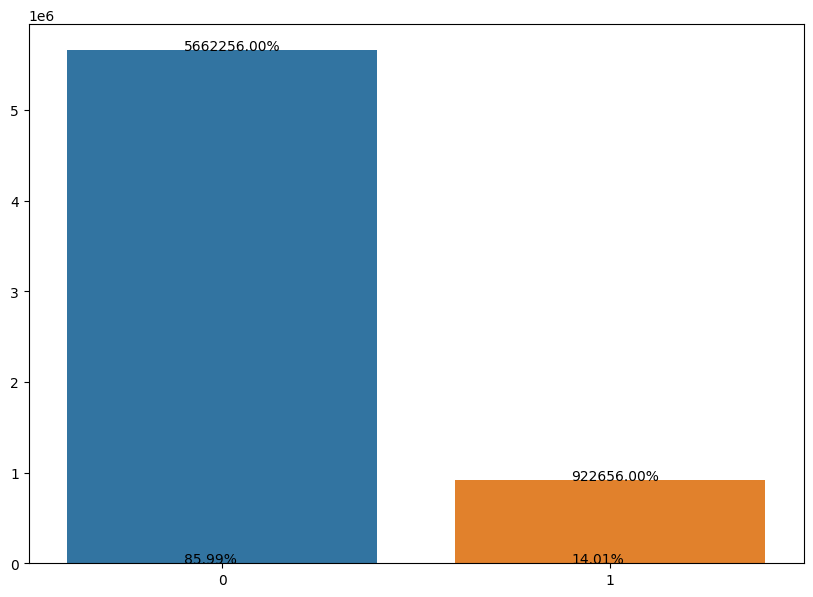

In [17]:
# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(dados_droped, 'trocou_aparelho')

In [18]:
dados_droped['dt_ano_stts'].unique()

array([2021, 2018, 2016, 2020, 2017, 2019, 2015, 2014, 2010, 2011, 2013,
       2012, 2009, 2007, 2006, 2008, 2004, 2005, 2001, 2022, 2003, 1999,
       2002, 2000], dtype=int64)

***
### Load Model

In [19]:
# Open saved model, and directly make the prediction with new data
filename = '../models/model_trocou_aparelho.pk'
with open(filename ,'rb') as f:
    pipeline_ta = pickle.load(f)

In [20]:
X_ta = dados_droped.drop('trocou_aparelho', axis=1)

y_ta = dados_droped['trocou_aparelho']

In [21]:
preds_ta = pipeline_ta.predict(X_ta)

AttributeError: 'ColumnTransformer' object has no attribute '_name_to_fitted_passthrough'

In [ ]:
c_val_ta = Counter(y_ta)
c_val_ta

In [ ]:
c_preds_ta = Counter(preds_ta)
c_preds_ta

***
## Métricas

In [ ]:
aucur(y_ta, preds_ta)

In [ ]:
print(classification_report(y_ta, preds_ta))

In [ ]:
cm_df_ta = pd.DataFrame(confusion_matrix(y_ta, preds_ta),
                        index = sorted(Counter(y_ta)),
                        columns = sorted(Counter(preds_ta)))
cm_df_ta

In [ ]:
# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        pipeline_ta,
        X_ta,
        y_ta,
        display_labels=['Não Trocou', 'Trocou'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    
plt.figure(figsize=(18, 18))
plt.show()

***
***
***
## Captação dos clientes que foram previstos como Propensos a Fazer uma Compra

Base Original

In [ ]:
X_ta['trocou_aparelho'] = y_ta
# X_ta

In [ ]:
plt.figure(figsize=(8, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(X_ta, 'trocou_aparelho')

Base Prevista

In [ ]:
X_ta['trocou_aparelho_previsto'] = preds_ta
# X_ta

In [ ]:
plt.figure(figsize=(8, 6))

plot_feature_freq(X_ta, 'trocou_aparelho_previsto')

In [ ]:
X_ta['cpfidentifier'] = dados_droped['cpfidentifier']
# X_ta

In [ ]:
X_ta['dt_inicio'] = dados_droped['dt_inicio']
# X_ta

In [ ]:
X_ta['dt_fim'] = dados_droped['dt_fim']
X_ta['modelo'] = dados_droped['modelo']
X_ta['subscribermainofferdesc'] = dados_droped['subscribermainofferdesc']
X_ta['assignedchargeamount'] = dados_droped['assignedchargeamount']
X_ta['offertechnology'] = dados_droped['offertechnology']
X_ta['statedesc'] = dados_droped['statedesc']
X_ta['fl_3g'] = dados_droped['fl_3g']
X_ta['fl_4g'] = dados_droped['fl_4g']
# X_ta['fl_5g'] = dados_droped['fl_5g']
X_ta['idade'] = dados_droped['idade']
X_ta['avg_msisdn'] = dados_droped['avg_msisdn']
X_ta['avg_cpf'] = dados_droped['avg_cpf']

X_ta

In [ ]:
val_acc_ta = accuracy_score(y_ta, preds_ta)
print('Validation Acuracy:', val_acc_ta)

***
***
***
## Separando as bases para outro modelo

In [ ]:
base_to_pred_month = X_ta[X_ta['trocou_aparelho_previsto'] == 1].reset_index(drop=True)
base_to_pred_month

***
***
***
## Definição do Target aging_aparelho

In [ ]:
# define target
y = base_to_pred_month['aging_aparelho']

In [ ]:
# contagem de aging
from collections import Counter

c = Counter(y)
c

In [ ]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq_mes(base_to_pred_month, 'aging_aparelho')

***
### Load Model

In [ ]:
# Open saved model, and directly make the prediction with new data
filename_ag = '/kaggle/input/models/model_aging.pk'
with open(filename_ag ,'rb') as f:
    pipeline = pickle.load(f)

In [ ]:
X = base_to_pred_month.drop('aging_aparelho', axis=1)

y = base_to_pred_month['aging_aparelho']

In [ ]:
preds = pipeline.predict(X)

In [ ]:
c_val = Counter(y)
c_val

In [ ]:
c_preds = Counter(preds)
c_preds

***
## Métricas

In [ ]:
y_probas = pipeline.predict_proba(X)
plot_roc(y, y_probas, plot_micro = False, plot_macro = False, figsize = (8, 8))
plt.show()

In [ ]:
print(classification_report(y, preds))

In [ ]:
cm_df = pd.DataFrame(confusion_matrix(y, preds),
                     index = sorted(Counter(y)),
                     columns = sorted(Counter(preds)))
cm_df

## Plot non-normalized confusion matrix

In [ ]:
y.unique()

In [ ]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        pipeline,
        X,
        y,
        display_labels=y.unique(),
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    
plt.figure(figsize=(25, 25))
plt.show()

***
## Mesclando resultados com tabela

### Com a base de validação

In [ ]:
X['aging_aparelho'] = y
# X

In [ ]:
X['previsto'] = preds
# X

In [ ]:
X['cpfidentifier'] = base_to_pred_month['cpfidentifier']
# X

In [ ]:
X['dt_inicio'] = base_to_pred_month['dt_inicio']
# X

In [ ]:
X['dt_fim'] = base_to_pred_month['dt_fim']
# X

***
## Calculando data prevista

In [ ]:
X['dt_fim_previsto'] = ((pd.to_datetime(X['dt_inicio']).dt.to_period('M')) + X['previsto'])
X

In [ ]:
val_acc = accuracy_score(y, preds)
print('Validation Acuracy:', val_acc)